In [1]:
# import pandas as pd
# import numpy as np
# import lightgbm as lgb
# import matplotlib.pyplot as plt
# import seaborn as sns
# import warnings
# from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
# from sklearn.metrics import make_scorer
# warnings.filterwarnings('ignore')

In [2]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import itertools

import warnings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
warnings.filterwarnings('ignore')

In [3]:
train = pd.read_csv("dataset_hosp_vacc.csv", parse_dates=["Date"])
test = pd.read_csv("dataset_hosp_vacc_test.csv", parse_dates=["Date"])
# sample_sub = pd.read_csv('demand_forecasting_datasets/sample_submission.csv')
df = pd.concat([train, test], sort=False)

df.head()

date_column = "Date" 
target_column= "new_hospitalized_patients"
feature_column_1 = "location_key"
feature_column_2 = "new_persons_vaccinated"
# date column name must me "date"

# #load dataset
# train = pd.read_csv('../input/demand-forecasting-kernels-only/train.csv', parse_dates=['date'])
# test = pd.read_csv('../input/demand-forecasting-kernels-only/test.csv', parse_dates=['date'])
# df = pd.concat([train, test], sort=False) # veri önişleme için test ve train bir araya getirdim
# df.head()

In [4]:
# df.info()

In [5]:
# df.dtypes


In [6]:
# date key field column name 
# date column name must me "date"

In [7]:
# print("Train set:",train.shape)
# print("Test set:",test.shape)

In [8]:
# combining the training and test dataset
# df = train +test


df.drop(['cumulative_hospitalized_patients','new_intensive_care_patients','cumulative_intensive_care_patients'], axis=1, inplace=True)
df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)


In [9]:
# using quantile function -transform a numeric input variable to have a different data distribution


df.quantile([0, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99, 1]).T

,0.00,0.05,0.25,0.50,0.75,0.95,0.99,1.00
new_hospitalized_patients,0.0,0.0,0.0,0.0,3.00,55.00,400.00,11246.0
current_hospitalized_patients,0.0,0.0,0.0,0.0,0.00,0.00,78.85,5390.0
current_intensive_care_patients,0.0,0.0,0.0,0.0,0.00,0.00,11.00,947.0
current_ventilator_patients,0.0,0.0,0.0,0.0,0.00,0.00,3.00,557.0
new_persons_vaccinated,-350160.0,0.0,1.0,8.0,45.00,3746.30,49346.49,2118821.0
cumulative_persons_vaccinated,0.0,5.0,635.0,2539.0,11327.00,1430258.65,9669134.16,174333400.0
new_persons_fully_vaccinated,-233678.0,0.0,0.0,5.0,35.00,2120.00,36719.67,1600527.0
cumulative_persons_fully_vaccinated,0.0,0.0,191.0,1246.0,6379.00,654110.25,7957102.00,152340188.0
new_vaccine_doses_administered,-296286.0,0.0,4.0,21.0,99.00,6827.00,86546.05,2979630.0
cumulative_vaccine_doses_administered,0.0,3.0,786.0,3604.5,16469.25,1385242.00,15924807.60,326673588.0


In [10]:


# df[date_column].min()

In [11]:
# df[date_column].max()

In [12]:
# 25% - The 25% percentile*.
# 50% - The 50% percentile*.
# 75% - The 75% percentile*.
# max - the maximum value.

# *Percentile meaning: how many of the values are less than the given percentile. Read more about percentiles in our Machine Learning Percentile chapter.

df[target_column].describe([0.10, 0.30, 0.50, 0.70, 0.80, 0.90, 0.95, 0.99])
# df["sales"].describe()

count    182816.000000
mean         23.715999
std         226.523171
min           0.000000
10%           0.000000
30%           0.000000
50%           0.000000
70%           2.000000
80%           4.000000
90%          15.000000
95%          55.000000
99%         400.000000
max       11246.000000
Name: new_hospitalized_patients, dtype: float64

In [13]:
# to find the number of unique values inthe column
#count og unique location keys


# df[feature_column_1].nunique()

In [14]:

# df[feature_column_2].nunique() 

In [15]:
# grouping the store column and finding the count of unique items in each store


# df.groupby([feature_column_1])[target_column].nunique()

In [16]:
# group by 2 coumns and finding sales sum and other parameters like mean median and mode

df.groupby([feature_column_1]).agg({target_column: ["sum", "mean", "median", "std"],feature_column_2: ["sum", "mean", "median", "std"]})

new_hospitalized_patients                                new_persons_vaccinated                                     
                                   sum        mean median         std                    sum          mean   median           std
location_key                                                                                                                     
AR                            232643.0  537.281755  494.0  285.035539                7803686  15670.052209  10155.0  14193.124025
AR_A                            8491.0   21.940568   18.0   13.273101                 125071    303.570388    195.5    375.188099
AR_A_007                         253.0    0.773700    0.0    1.152822                   8169     23.406877     14.0     28.693597
AR_A_014                          73.0    0.270370    0.0    0.607460                   1155      3.969072      1.0      6.649014
AR_A_021                          64.0    0.226950    0.0    0.538468                   1434      4.764120      3.0      6.317767
...                                ...         ...    ...         ...                    ...           ...      ...           ...
BR_RR                           4662.0    7.459200    5.0    8.123960                 372636    581.335413      0.0   1459.914476
BR_RS                         113073.0  158.587658   99.0  184.288683                9637506  12532.517555      0.0  22221.724836
BR_SC                          74842.0  104.967742   71.0  106.901024                6288027   8198.209909      0.0  19220.451439
BR_SE                          17663.0   27.049005   19.0   26.827283                1893378   2760.026239      0.0   5269.703497
BR_SP                         526350.0  714.179104  540.0  678.697006               44892758  55767.401242  10691.0  96191.354060

[580 rows x 8 columns]

In [17]:
df['month'] = df.Date.dt.month

df['day_of_month'] = df.Date.dt.day

df['day_of_year'] = df.Date.dt.dayofyear 

df['week_of_year'] = df.Date.dt.weekofyear

df['day_of_week'] = df.Date.dt.dayofweek

df['year'] = df.Date.dt.year

df["is_wknd"] = df.Date.dt.weekday // 4

df['is_month_start'] = df.Date.dt.is_month_start.astype(int)

df['is_month_end'] = df.Date.dt.is_month_end.astype(int) 

In [18]:
df.head()

,Date,location_key,new_hospitalized_patients,current_hospitalized_patients,current_intensive_care_patients,current_ventilator_patients,new_persons_vaccinated,cumulative_persons_vaccinated,new_persons_fully_vaccinated,cumulative_persons_fully_vaccinated,new_vaccine_doses_administered,cumulative_vaccine_doses_administered,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end
0,2020-02-12,AU,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0.0,2,12,43,7,2,2020,0,0,0
1,2020-02-13,AU,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0.0,2,13,44,7,3,2020,0,0,0
2,2020-02-20,AU,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0.0,2,20,51,8,3,2020,0,0,0
3,2020-02-26,BR,1.0,0.0,0.0,0.0,0,0,0,0,0.0,0.0,2,26,57,9,2,2020,0,0,0
4,2020-02-28,AU,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0.0,2,28,59,9,4,2020,1,0,0


In [19]:
# month wise grouping

df.groupby([feature_column_1, "month"]).agg({target_column: ["sum", "mean", "median", "std"]})

new_hospitalized_patients                                 
                                         sum         mean  median         std
location_key month                                                           
AR           1                       36036.0   581.225806   574.5  113.777957
             2                       19841.0   367.425926   386.5  111.581699
             3                       16801.0   430.794872   477.0  139.916362
             4                       25348.0   844.933333   854.5  153.187497
             5                       32381.0  1044.548387  1045.0  161.952017
...                                      ...          ...     ...         ...
BR_SP        8                       34736.0   560.258065   523.0  232.440998
             9                       23871.0   397.850000   336.5  184.935520
             10                      16269.0   262.403226   212.0  149.040259
             11                      17357.0   289.283333   156.5  259.974972
             12                      21812.0   351.806452    91.5  383.679419

[6930 rows x 4 columns]

In [20]:
# random noise function 

def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))

In [21]:

# sorting according to date

df.sort_values(by=[feature_column_1, 'Date'], axis=0, inplace=True)
# df.head()

In [22]:
# lag features function 


def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby([feature_column_1])[target_column].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

df = lag_features(df, [91, 98, 105, 112, 119, 126, 182, 364, 546, 728])

In [23]:
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby([feature_column_1])[target_column]. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe


df = roll_mean_features(df, [365, 546, 730])

In [24]:
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby([feature_column_1])[target_column].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe


alphas = [0.99, 0.95, 0.9, 0.8, 0.7, 0.5]
lags = [91, 98, 105, 112, 180, 270, 365, 546, 728]

df = ewm_features(df, alphas, lags)
# df.tail()

In [25]:


df = pd.get_dummies(df, columns=['day_of_week', 'month'])

In [26]:
# [feature_column_1, feature_column_2])[target_column

df[target_column] = np.log1p(df[target_column].values)

In [35]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['location_key'] = le.fit_transform(df['location_key'])
# df['location_key'] = le.fit_transform(df['location_key'])
   
    


In [36]:
# df.head(5)

In [37]:

train = df.loc[(df[date_column] < "2022-01-01"), :]
# train  = train.apply(le.fit_transform)


val = df.loc[(df[date_column] >= "2020-01-25") & (df[date_column] < "2022-01-01"), :]
# val  = val.apply(le.fit_transform)


cols = [col for col in train.columns if col not in [date_column, 'id', target_column, "year"]]

In [38]:

Y_train = train[target_column]


X_train = train[cols]


Y_val = val[target_column]


X_val = val[cols] 


Y_train.shape, X_train.shape, Y_val.shape, X_val.shape


((169184,), (169184, 102), (169184,), (169184, 102))

In [46]:
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val


def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

In [47]:
lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 10000, 
              'early_stopping_rounds': 200,
              'nthread': -1}

In [48]:
lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)
lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)

model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'],
                  early_stopping_rounds=lgb_params['early_stopping_rounds'],
                  feval=lgbm_smape, 
                  verbose_eval=100)

y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)


smape(np.expm1(y_pred_val), np.expm1(Y_val))

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024601 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.47258	training's SMAPE: 144.304	valid_1's l1: 0.471938	valid_1's SMAPE: 144.269
[200]	training's l1: 0.390141	training's SMAPE: 143.766	valid_1's l1: 0.388241	valid_1's SMAPE: 143.553
[300]	training's l1: 0.366856	training's SMAPE: 143.23	valid_1's l1: 0.365121	valid_1's SMAPE: 143.028
[400]	training's l1: 0.356653	training's SMAPE: 142.662	valid_1's l1: 0.354985	valid_1's SMAPE: 142.479
[500]	training's l1: 0.350193	training's SMAPE: 142.226	valid_1's l1: 0.348548	valid_1's SMAPE: 142.047
[600]	training's l1: 0.345209	training's SMAPE: 141.874	valid_1's l1: 0.343736	valid_1's SMAPE: 141.693
[700]	training's l1: 0.341147	training's SMAPE: 141.562	valid_1's l1: 0.339801	valid_1'

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6900]	training's l1: 0.281837	training's SMAPE: 136.981	valid_1's l1: 0.281384	valid_1's SMAPE: 136.746
[7000]	training's l1: 0.281489	training's SMAPE: 136.95	valid_1's l1: 0.281083	valid_1's SMAPE: 136.717
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7100]	training's l1: 0.281119	training's SMAPE: 136.921	valid_1's l1: 0.280729	valid_1's SMAPE: 136.69
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7200]	training's l1: 0.280775	training's SMAPE: 136.892	valid_1's l1: 0.280403	valid_1's SMAPE: 136.663
[7300]	training's l1: 0.280398	training's SMAPE: 136.863	valid_1's l1: 0.280034	valid_1's SMAPE: 136.634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

135.98559273645085

In [49]:
#Final Model



train = df.loc[~df.new_hospitalized_patients.isna()]
Y_train = train[target_column]
X_train = train[cols]

test = df.loc[df.new_hospitalized_patients.isna()]
X_test = test[cols]

In [50]:
df['location_key'] = le.fit_transform(df['location_key'])



In [51]:
lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'nthread': -1,
              "num_boost_round": model.best_iteration}

# LightGBM dataset

lgbtrain_all = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

model = lgb.train(lgb_params, lgbtrain_all, num_boost_round=model.best_iteration)
test_preds = model.predict(X_test, num_iteration=model.best_iteration)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080639 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

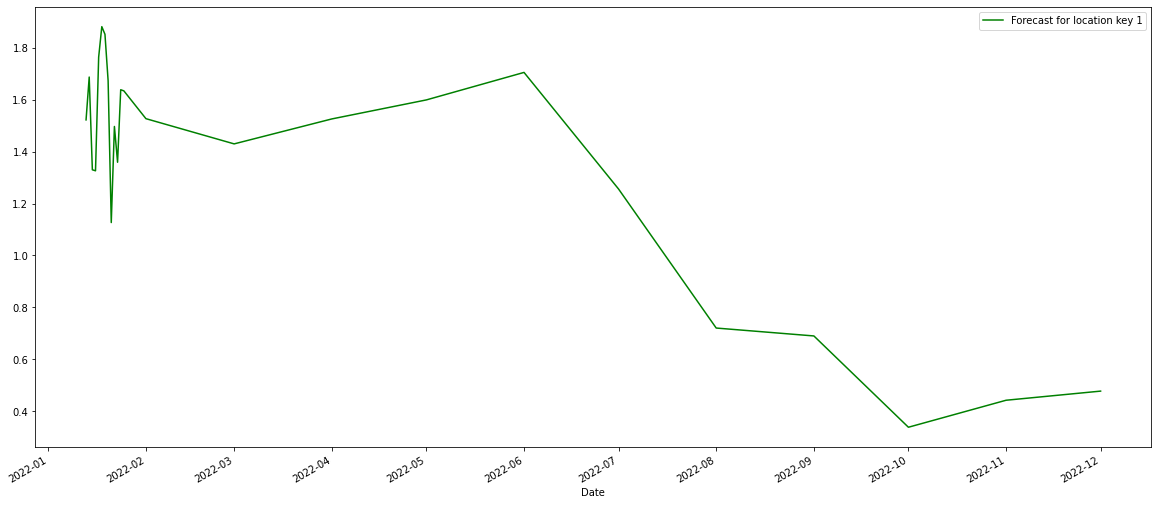

In [52]:
# [feature_column_1, feature_column_2])[target_column

forecast = pd.DataFrame({date_column:test[date_column],
                        feature_column_1:test[feature_column_1],
#                         feature_column_2:test[feature_column_2],
                        target_column:test_preds
                        })

forecast[(forecast[feature_column_1] == 100) ].set_index(date_column).new_hospitalized_patients.plot(color = "green",
                                                                                    figsize = (20,9),
                                                                                    legend=True, label = "Forecast for location key 1");

In [56]:
def f(x):
    input_location_key = x
    train[(train[feature_column_1] == input_location_key) ].set_index(date_column).new_hospitalized_patients.plot(figsize = (20,9),legend=True, label = "Training for location key = %i" % input_location_key)
    forecast[(forecast[feature_column_1] == input_location_key)].set_index(date_column).new_hospitalized_patients.plot(legend=True, label =  "Forecast for location key = %i" % input_location_key);

In [57]:
# input_location_key = 10
# train[(train[feature_column_1] == input_location_key) ].set_index(date_column).new_hospitalized_patients.plot(figsize = (20,9),legend=True, label = "Training for location key = %i" % input_location_key)
# forecast[(forecast[feature_column_1] == input_location_key)].set_index(date_column).new_hospitalized_patients.plot(legend=True, label =  "Forecast for location key = %i" % input_location_key);

In [68]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

F1 = widgets.IntSlider(value=5, min=0, max=500)

interactive(f,x=F1)


interactive(children=(IntSlider(value=5, description='x', max=500), Output()), _dom_classes=('widget-interact'…

In [59]:
df.shape

(196448, 105)

In [60]:
forecast[forecast[feature_column_1] == 7]

,Date,location_key,new_hospitalized_patients
6234,2022-01-13,7,0.580642
6718,2022-01-14,7,0.662483
7124,2022-01-15,7,0.678045
7859,2022-01-17,7,0.854888
8683,2022-01-18,7,0.748469
9162,2022-01-19,7,0.864148
9522,2022-01-20,7,0.647037
10218,2022-01-21,7,0.735822
10950,2022-01-22,7,0.730195
11608,2022-01-24,7,0.719300


In [61]:
df['location_key']

957         0
156451      0
1032        0
156511      0
45943       0
         ... 
5101      579
12994     579
13609     579
5371      579
13030     579
Name: location_key, Length: 196448, dtype: int64

In [63]:
# y_train_encoded = y_train.apply(le().fit_transform)
# y_test_encoded = y_test.apply(le().fit_transform)

# df['location_key'] =le.inverse_transform(y_pred)
# y_pred_inverse = le.inverse_transform(y_pred)
df_loc_key = df['location_key']

In [67]:
print(df_loc_key.tail(10))

3947     579
12948    579
13575    579
4303     579
12979    579
5101     579
12994    579
13609    579
5371     579
13030    579
Name: location_key, dtype: int64
